In [1]:
import pandas as pd

sre = pd.read_csv(r"C:\LCD\GIT\self\Resume\Resume\diffbot-export.csv")
ne = pd.read_csv(r"C:\LCD\GIT\self\Resume\Resume\networkengineer.csv")

sre["title"] = ["Site Reliability Engineer"] * len (sre)
ne["title"] = ["Network Engineer"] * len (ne)
 
df = pd.concat([sre, ne]).reset_index(drop=True)
df = df[~df.text.isna()]

In [2]:
from yarl import URL

def get_page_source(url: str):
    return URL(url).host

df["page_host"] = df["pageUrl"].apply(get_page_source)

In [3]:
import plotly.express as px

top_pages = df["page_host"].value_counts()[:20].to_frame()

fig = px.histogram(
    top_pages,
    x=top_pages.index,
    y="page_host",
    labels={"sum of page_host": "frequency", "index": "page host"},
).update_xaxes(
    categoryorder="total descending",
)

fig

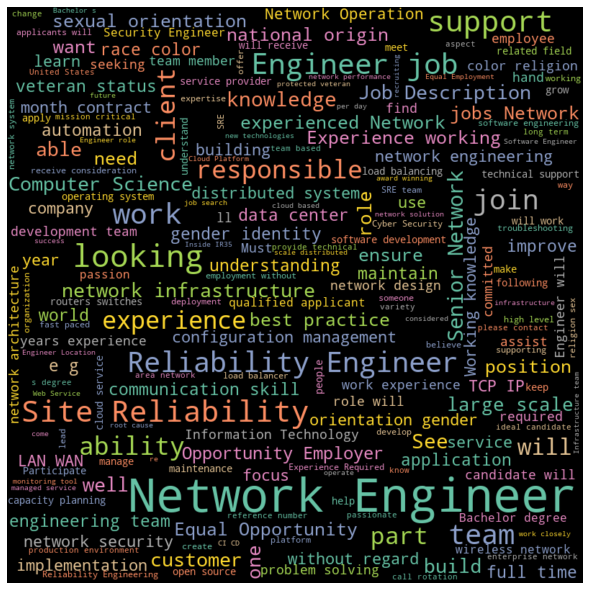

In [4]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

%matplotlib inline


def make_wordcloud(new_text):
    """'function to make wordcloud"""

    wordcloud = WordCloud(
        width=800,
        height=800,
        min_font_size=10,
        background_color="black",
        colormap="Set2",
        collocation_threshold=3,
    ).generate(new_text)

    fig = plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

    return fig

text = " ".join(df["text"].values)
text_cloud = make_wordcloud(text)

In [5]:
import scattertext as st

analyze_col = "requirements"

# Filter out the rows whose requirement is nan
filtered_df = df[~df[analyze_col].isna()][["title", analyze_col, "page_host"]]

# Tokenize text
filtered_df["parse"] = filtered_df[analyze_col].apply(st.whitespace_nlp_with_sentences)

corpus = (
    st.CorpusFromParsedDocuments(filtered_df, category_col="title", parsed_col="parse")
    .build()
    .get_unigram_corpus()
    .compact(st.AssociationCompactor(2000))
)

In [6]:
import nltk
nltk.download("averaged_perceptron_tagger")

# get DataFrame with terms and their frequency
term_freq_df = corpus.get_term_freq_df()

# Get scaled F-scores of each term in each category
term_freq_df["Site Reliability Engineer"] = corpus.get_scaled_f_scores("Site Reliability Engineer")
term_freq_df["Network Engineer"] = corpus.get_scaled_f_scores("Network Engineer")

# Remove terms that are not nouns
def is_noun(word: str):
    pos = nltk.pos_tag([word])[0][1]
    return pos[:2] == "NN"

term_freq_df = term_freq_df.loc[map(is_noun, term_freq_df.index)]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\luke0\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
term_freq_df.sort_values(by="Site Reliability Engineer", ascending=False).index[:40]

Index(['python', 'linux', 'tools', 'systems', 'etc', 'cloud', 'experience',
       'scale', 'java', 'monitoring', 'software', 'skills', 'service',
       'ability', 'aws', 'docker', 'development', 'environment', 'work',
       'automation', 'code', 'years', 'management', 'c', 'system',
       'communication', 'services', 'ruby', 'knowledge', 'kubernetes',
       'infrastructure', 'shell', 'unix', 'building', 'science', 'problem',
       'computer', 'oracle', 'team', 'dbaas'],
      dtype='object', name='term')

In [8]:
term_freq_df.sort_values(by="Network Engineer", ascending=False).index[:40]

Index(['cisco', 'wireless', 'network', 'wan', 'security', 'lan', 'support',
       'networks', 'ccnp', 'switches', 'certification', 'routers', 'degree',
       'level', 'technology', 'information', 'bgp', 'solutions', 'ccna',
       'enterprise', 'protocols', 'certifications', 'vpn', 'ospf',
       'implementation', 'access', 'project', 'microsoft', 'customer',
       'engineer', 'bachelor', 'firewalls', 'requirements', 'hardware',
       'center', 'minimum', 'firewall', 'business', 'documentation', 'mpls'],
      dtype='object', name='term')

In [11]:
import re

html = st.produce_scattertext_explorer(
    corpus,
    category="Site Reliability Engineer",
    category_name="Site Reliability Engineer",
    not_category_name="Network Engineer",
    minimum_term_frequency=5,
    pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    metadata=corpus.get_df()["page_host"],
    transform=st.Scalers.dense_rank,
)

str = html
Output = re.sub(r"(\u0120)", "", str)

open("site_reliability_engineer_vs_network_engineer.html", "w").write(Output)

1143282